In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

from summer2 import CompartmentalModel
from summer2.parameters import Parameter, DerivedOutput

In [2]:
def build_seir_model(
    config: dict,
) -> CompartmentalModel:
    
    # Model characteristics
    compartments = ("Susceptible", "Pre-infectious", "Infectious", "Immune")
    model = CompartmentalModel(
        times=(0., config["end_time"]),
        compartments=compartments,
        infectious_compartments=["Infectious"],
        timestep=config["t_step"],
    )
    n_immune_0 = config["prop_immune_0"] * config["tot_popn"]
    model.set_initial_population(
        distribution={
            "Susceptible": config["tot_popn"] - config["infous_0"] - n_immune_0, 
            "Infectious": config["infous_0"],
            "Immune": n_immune_0,
        }
    )
    
    # Transitions
    ave_infous = Parameter("ave_infous")
    model.add_infection_frequency_flow(
        name="infection", 
        contact_rate=Parameter("r0") / ave_infous,
        source="Susceptible",
        dest="Pre-infectious"
    )
    model.add_transition_flow(
        name="progression", 
        fractional_rate=1. / Parameter("ave_preinfous"),
        source="Pre-infectious", 
        dest="Infectious"
    )
    model.add_transition_flow(
        name="recovery", 
        fractional_rate=1. / ave_infous,
        source="Infectious", 
        dest="Immune"
    )
    
    # Outputs
    model.request_output_for_flow(
        name="incidence", 
        flow_name="progression"
    )
    model.request_function_output(
        name="incidence_per_tstep",
        func=DerivedOutput("incidence") * config["t_step"],
    )
    
    return model

In [3]:
model_config = {
    "tot_popn": 5234.,
    "infous_0": 2.,
    "end_time": 120.,
    "t_step": 0.5,
    "prop_immune_0": 0.3,
}

parameters = {
    "r0": 2.1,
    "ave_preinfous": 2.,
    "ave_infous": 2.,
    "life_expectancy": 70.,
}

In [4]:
seir_model_part_immune = build_seir_model(model_config)
seir_model_part_immune.run(parameters=parameters)
compartment_values = seir_model_part_immune.get_outputs_df()
derived_outputs = seir_model_part_immune.get_derived_outputs_df()

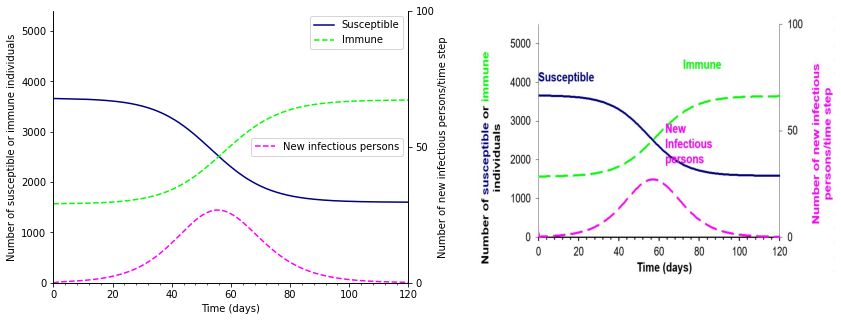

In [5]:
fig, (left_ax, right_ax) = plt.subplots(1, 2, figsize=(14, 5))
twin_ax = left_ax.twinx()

left_ax.plot(
    seir_model_part_immune.times, 
    compartment_values["Susceptible"], 
    color="navy", 
    label="Susceptible",
)
left_ax.plot(
    seir_model_part_immune.times, 
    compartment_values["Immune"], 
    color="lime", 
    linestyle="--", 
    label="Immune",
)
left_ax.set_xlim(0., 120.)
left_ax.xaxis.set_minor_locator(AutoMinorLocator(5))
left_ax.set_xlabel("Time (days)")
left_ax.set_ylim(0., 5400.)
left_ax.set_ylabel("Number of susceptible or immune individuals")
left_ax.legend()
left_ax.spines.top.set_visible(False)

twin_ax.plot(
    seir_model_part_immune.times, 
    derived_outputs["incidence_per_tstep"], 
    color="magenta", 
    linestyle="--", 
    label="New infectious persons",
)
twin_ax.set_ylim(0., 1e2)
twin_ax.set_yticks(range(0, 150, 50))
twin_ax.set_ylabel("Number of new infectious persons/time step")
twin_ax.legend(loc=5)
twin_ax.spines.top.set_visible(False)

image = plt.imread("./figures/model_4_2_fig.JPG")
right_ax.axis("off")
right_ax.imshow(image, aspect="auto");